In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneGroupOut

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [5]:
training_dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Data/Training_set"
testing_dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Data/Test_set"

datasets = {
    "train": [os.path.join(training_dataset_dir, f) for f in os.listdir(training_dataset_dir) if f.endswith('.npz')],
    "test": [os.path.join(testing_dataset_dir, f) for f in os.listdir(testing_dataset_dir) if f.endswith('.npz')]
}

print(f"Training files: {len(datasets['train'])}, Testing files: {len(datasets['test'])}")


Training files: 18635, Testing files: 4828


## Classification between three classes [Low, Medium, High forces] 

In [7]:
## [20-40] --> Low
## [40-60] --> Medium
## [60-80] --> High
def categorize_target_force(target_force):
    if target_force <= 40:
        return 0  # Small
    elif target_force <= 60:
        return 1  # Middle
    else:
        return 2  # High
    
def load_data(npz_files):
    X = []
    y = []
    participants = []  # Store participant IDs

    for file_path in npz_files:
        data = np.load(file_path)

        eit_data = data['eit']
        target_force = data['target_force']
        
        # Flatten the 16x16 EIT data
        eit_data_flat = eit_data.reshape(-1)

        # Get participant ID
        participant_id = data['participant'].item()  # Ensure it's a string like "P07"

        X.append(eit_data_flat)
        y.append(categorize_target_force(target_force))
        participants.append(participant_id)

    return np.array(X), np.array(y), participants

In [8]:
# Load training and testing data separately
X_train, y_train, participants_train = load_data(datasets['train'])
X_test, y_test, participants_test = load_data(datasets['test'])

# Print dataset sizes
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")



Training set: 18635 samples
Testing set: 4828 samples


Class Weights: {0: np.float64(1.2003220611916263), 1: np.float64(1.148819431601011), 2: np.float64(0.7713481518274763)}
Epoch 1/100


/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5495 - loss: 0.9511 - val_accuracy: 0.4186 - val_loss: 1.6820
Epoch 2/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.7523 - loss: 0.5408 - val_accuracy: 0.4070 - val_loss: 1.9593
Epoch 3/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.7952 - loss: 0.4429 - val_accuracy: 0.4217 - val_loss: 2.7530
Epoch 4/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8161 - loss: 0.4039 - val_accuracy: 0.4147 - val_loss: 3.9243
Epoch 5/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.8376 - loss: 0.3612 - val_accuracy: 0.4180 - val_loss: 4.9310
Epoch 6/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.8565 - loss: 0.3245 - val_accuracy: 0.4211 - val_loss: 5.9506
Epoch 7/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8637 - loss: 0.3117 - val_accuracy: 0.4712 - val_loss: 6.3433
Epoch 8/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.8772 - loss: 0.2786 - val_accura

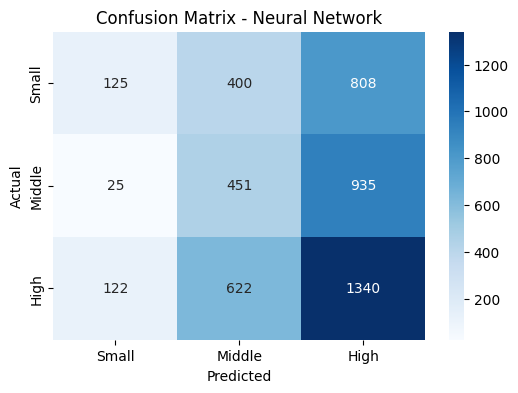

              precision    recall  f1-score   support

       Small       0.46      0.09      0.16      1333
      Middle       0.31      0.32      0.31      1411
        High       0.43      0.64      0.52      2084

    accuracy                           0.40      4828
   macro avg       0.40      0.35      0.33      4828
weighted avg       0.40      0.40      0.36      4828



In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ 1. Load Data
training_dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Data/Training_set"
testing_dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Data/Test_set"

npz_files_train = [f for f in os.listdir(training_dataset_dir) if f.endswith('.npz')]
npz_files_test = [f for f in os.listdir(testing_dataset_dir) if f.endswith('.npz')]

X_train, y_train = [], []
X_test, y_test = [], []

# ✅ 2. Read Training Data
for file in npz_files_train:
    file_path = os.path.join(training_dataset_dir, file)
    data = np.load(file_path)

    eit_data_flat = data['eit'].reshape(-1)  # Flatten 16x16 frames
    target_force = data['target_force']

    X_train.append(eit_data_flat)
    y_train.append(target_force)

# ✅ 3. Read Testing Data
for file in npz_files_test:
    file_path = os.path.join(testing_dataset_dir, file)
    data = np.load(file_path)

    eit_data_flat = data['eit'].reshape(-1)
    target_force = data['target_force']

    X_test.append(eit_data_flat)
    y_test.append(target_force)

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# ✅ 4. Standardize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ 5. Convert Labels to Categorical
# Define function to categorize force values
def categorize_force(value):
    if 20 <= value < 40:
        return 0  # Small
    elif 40 <= value < 60:
        return 1  # Middle
    elif 60 <= value <= 80:
        return 2  # High
    else:
        raise ValueError(f"Unexpected force value: {value}")

# Apply categorization to y_train and y_test
y_train = np.array([categorize_force(val) for val in y_train])
y_test = np.array([categorize_force(val) for val in y_test])

num_classes = 3  # Assuming 3 categories: Small, Middle, High
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# ✅ 6. Compute Class Weights (to handle imbalance)
y_train_labels = np.argmax(y_train, axis=1)  # Convert one-hot to labels
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = {i: class_weights[i] for i in range(num_classes)}

print("Class Weights:", class_weight_dict)

# ✅ 7. Build the Neural Network Model
def create_model():
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),

        layers.Dense(num_classes, activation="softmax")  # Multi-class classification
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# ✅ 8. Train the Model
model = create_model()
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,  # Handle class imbalance
    verbose=1
)

# ✅ 9. Evaluate Model Performance
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")

# ✅ 10. Make Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# ✅ 11. Confusion Matrix & Classification Report
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Small", "Middle", "High"], yticklabels=["Small", "Middle", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Neural Network")
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=["Small", "Middle", "High"]))


Original training class distribution: Counter({np.int64(2): 8053, np.int64(1): 5407, np.int64(0): 5175})
Original testing class distribution: Counter({np.int64(2): 2084, np.int64(1): 1411, np.int64(0): 1333})
Class weights: {0: np.float64(1.2003220611916263), 1: np.float64(1.148819431601011), 2: np.float64(0.7713481518274763)}


/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,931 (425.51 KB)

 Trainable params: 108,035 (422.01 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4902 - loss: 1.1574 - val_accuracy: 0.5222 - val_loss: 1.5385
Epoch 2/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7050 - loss: 0.6380 - val_accuracy: 0.4714 - val_loss: 2.3562
Epoch 3/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7638 - loss: 0.5119 - val_accuracy: 0.4517 - val_loss: 2.7699
Epoch 4/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7840 - loss: 0.4650 - val_accuracy: 0.4196 - val_loss: 2.8739
Epoch 5/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8141 - loss: 0.4154 - val_accuracy: 0.4391 - val_loss: 3.0555
Epoch 6/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8317 - loss: 0.3745 - val_accuracy: 0.4360 - val_loss: 3.3251
Epoch 7/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8449 - loss: 0.3475 - val_accuracy: 0.4337 - val_loss: 3.6478
Epoch 8/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8527 - loss: 0.3406 - val_accu

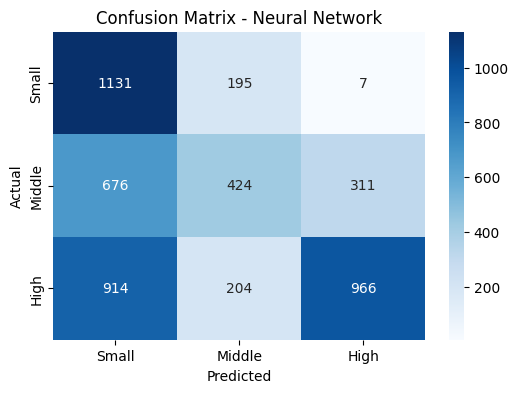

              precision    recall  f1-score   support

       Small       0.42      0.85      0.56      1333
      Middle       0.52      0.30      0.38      1411
        High       0.75      0.46      0.57      2084

    accuracy                           0.52      4828
   macro avg       0.56      0.54      0.50      4828
weighted avg       0.59      0.52      0.51      4828



In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler  # Alternatively, you can try MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Optional: For oversampling minority classes (uncomment if needed)
#from imblearn.over_sampling import SMOTE

# ------------------------------
# 1. Define Data Directories
# ------------------------------
training_dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Data/Training_set"
testing_dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Data/Test_set"

# ------------------------------
# 2. Categorize Force Values
# ------------------------------
def categorize_force(value):
    """
    Categorizes force into three classes:
    0: Small (20 <= force < 40)
    1: Middle (40 <= force < 60)
    2: High (60 <= force <= 80)
    """
    if 20 <= value < 40:
        return 0  # Small
    elif 40 <= value < 60:
        return 1  # Middle
    elif 60 <= value <= 80:
        return 2  # High
    else:
        raise ValueError(f"Unexpected force value: {value}")

# ------------------------------
# 3. Load Data from .npz Files
# ------------------------------
# Load training data
npz_files_train = [f for f in os.listdir(training_dataset_dir) if f.endswith('.npz')]
X_train_list, y_train_list = [], []

for file in npz_files_train:
    file_path = os.path.join(training_dataset_dir, file)
    data = np.load(file_path)
    # Flatten the 16x16 EIT data into a 1D vector
    eit_data_flat = data['eit'].reshape(-1)
    target_force = data['target_force']
    
    X_train_list.append(eit_data_flat)
    y_train_list.append(categorize_force(target_force))

# Load testing data
npz_files_test = [f for f in os.listdir(testing_dataset_dir) if f.endswith('.npz')]
X_test_list, y_test_list = [], []

for file in npz_files_test:
    file_path = os.path.join(testing_dataset_dir, file)
    data = np.load(file_path)
    eit_data_flat = data['eit'].reshape(-1)
    target_force = data['target_force']
    
    X_test_list.append(eit_data_flat)
    y_test_list.append(categorize_force(target_force))

# Convert lists to numpy arrays
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

print("Original training class distribution:", Counter(y_train))
print("Original testing class distribution:", Counter(y_test))

# ------------------------------
# 4. Scale the Features
# ------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------------------
# 5. Optional: Balance Training Data using SMOTE
# ------------------------------
# SMOTE works on integer labels, so apply it before one-hot encoding.
#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)
#print("After SMOTE, training class distribution:", Counter(y_train))

# ------------------------------
# 6. Convert Labels to Categorical (One-Hot Encoding)
# ------------------------------
num_classes = 3
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# ------------------------------
# 7. Compute Class Weights
# ------------------------------
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(num_classes)}
print("Class weights:", class_weight_dict)

# ------------------------------
# 8. Build a More Complex Neural Network Model
# ------------------------------
def create_model():
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

# ------------------------------
# 9. Train the Model with Early Stopping
# ------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

# ------------------------------
# 10. Evaluate the Model
# ------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")

# ------------------------------
# 11. Generate Predictions and Evaluate with a Confusion Matrix
# ------------------------------
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Small", "Middle", "High"],
            yticklabels=["Small", "Middle", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Neural Network")
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=["Small", "Middle", "High"]))


Original training class distribution: Counter({np.int64(2): 8053, np.int64(1): 5407, np.int64(0): 5175})
Original testing class distribution: Counter({np.int64(2): 2084, np.int64(1): 1411, np.int64(0): 1333})
Class weights: {0: np.float64(1.2003220611916263), 1: np.float64(1.148819431601011), 2: np.float64(0.7713481518274763)}


/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,131 (625.51 KB)

 Trainable params: 159,427 (622.76 KB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7388 - loss: 0.6267 - val_accuracy: 0.4182 - val_loss: 2.3439
Epoch 2/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8958 - loss: 0.2649 - val_accuracy: 0.4633 - val_loss: 3.8291
Epoch 3/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9247 - loss: 0.1905 - val_accuracy: 0.4316 - val_loss: 4.5721
Epoch 4/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9399 - loss: 0.1525 - val_accuracy: 0.4316 - val_loss: 4.5816
Epoch 5/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9513 - loss: 0.1262 - val_accuracy: 0.4316 - val_loss: 3.1433
Epoch 6/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9601 - loss: 0.1054 - val_accuracy: 0.4275 - val_loss: 3.1823
Epoch 7/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9599 - loss: 0.1083 - val_accuracy: 0.4335 - val_loss: 4.4325
Epoch 8/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9711 - loss: 0.0746 - val_accu

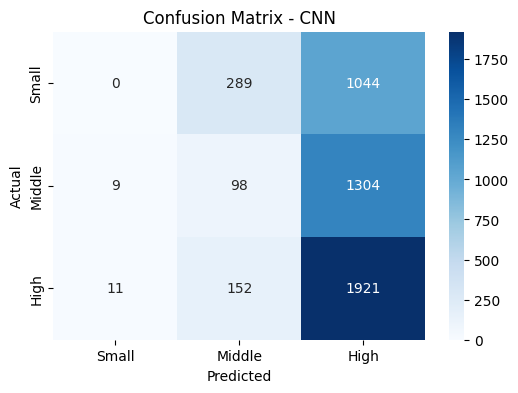

              precision    recall  f1-score   support

       Small       0.00      0.00      0.00      1333
      Middle       0.18      0.07      0.10      1411
        High       0.45      0.92      0.60      2084

    accuracy                           0.42      4828
   macro avg       0.21      0.33      0.24      4828
weighted avg       0.25      0.42      0.29      4828



In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
#from imblearn.over_sampling import SMOTE

# ------------------------------
# 1. Define Data Directories
# ------------------------------
training_dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Data/Training_set"
testing_dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Data/Test_set"

# ------------------------------
# 2. Categorize Force Values
# ------------------------------
def categorize_force(value):
    """
    Categorizes force into three classes:
    0: Small (20 <= force < 40)
    1: Middle (40 <= force < 60)
    2: High (60 <= force <= 80)
    """
    if 20 <= value < 40:
        return 0  # Small
    elif 40 <= value < 60:
        return 1  # Middle
    elif 60 <= value <= 80:
        return 2  # High
    else:
        raise ValueError(f"Unexpected force value: {value}")

# ------------------------------
# 3. Load Data from .npz Files
# ------------------------------
# Load training data
npz_files_train = [f for f in os.listdir(training_dataset_dir) if f.endswith('.npz')]
X_train_list, y_train_list = [], []

for file in npz_files_train:
    file_path = os.path.join(training_dataset_dir, file)
    data = np.load(file_path)
    # Flatten the 16x16 EIT data into a 1D vector
    eit_data_flat = data['eit'].reshape(16, 16, 1)  # Reshaping for CNN (height, width, channels)
    target_force = data['target_force']
    
    X_train_list.append(eit_data_flat)
    y_train_list.append(categorize_force(target_force))

# Load testing data
npz_files_test = [f for f in os.listdir(testing_dataset_dir) if f.endswith('.npz')]
X_test_list, y_test_list = [], []

for file in npz_files_test:
    file_path = os.path.join(testing_dataset_dir, file)
    data = np.load(file_path)
    eit_data_flat = data['eit'].reshape(16, 16, 1)  # Reshaping for CNN (height, width, channels)
    target_force = data['target_force']
    
    X_test_list.append(eit_data_flat)
    y_test_list.append(categorize_force(target_force))

# Convert lists to numpy arrays
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

print("Original training class distribution:", Counter(y_train))
print("Original testing class distribution:", Counter(y_test))

# ------------------------------
# 4. Scale the Features
# ------------------------------
# Optional: Use StandardScaler or MinMaxScaler if needed.
scaler = StandardScaler()
X_train = X_train.reshape(-1, 16*16)  # Flatten to use scaler
X_test = X_test.reshape(-1, 16*16)  # Flatten to use scaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape back to 16x16 for CNN
X_train = X_train.reshape(-1, 16, 16, 1)
X_test = X_test.reshape(-1, 16, 16, 1)

# ------------------------------
# 5. Optional: Balance Training Data using SMOTE
# ------------------------------
# SMOTE works on integer labels, so apply it before one-hot encoding.
#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
#X_train = X_train.reshape(-1, 16, 16, 1)  # Reshape back to 16x16 for CNN
#print("After SMOTE, training class distribution:", Counter(y_train))

# ------------------------------
# 6. Convert Labels to Categorical (One-Hot Encoding)
# ------------------------------
num_classes = 3
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# ------------------------------
# 7. Compute Class Weights
# ------------------------------
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(num_classes)}
print("Class weights:", class_weight_dict)

# ------------------------------
# 8. Build the CNN Model with Padding and Adjusted Pooling
# ------------------------------
def create_cnn_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(16, 16, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),  # Use 'same' padding to prevent dimension reduction
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        
        layers.Flatten(),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
cnn_model.summary()

# ------------------------------
# 9. Train the Model with Early Stopping
# ------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = cnn_model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

# ------------------------------
# 10. Evaluate the CNN Model
# ------------------------------
test_loss, test_acc = cnn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")

# ------------------------------
# 11. Generate Predictions and Evaluate with a Confusion Matrix
# ------------------------------
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Small", "Middle", "High"],
            yticklabels=["Small", "Middle", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN")
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=["Small", "Middle", "High"]))


In [7]:
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split

X = []
y = []
participants = []  # Store participant IDs

# Load data and keep track of participant ID
for file in npz_files:
    file_path = os.path.join(dataset_dir, file)
    data = np.load(file_path)

    eit_data = data['eit']
    target_force = data['target_force']
    # flatten the eit data
    eit_data_flat = eit_data.reshape(-1)
    
    participant_id = data['participant'].item()  # Ensure it's a string like "P07"
    
    eit_data_flat = eit_data.reshape(-1)  # Flatten the 16x16 frames into a single vector

    X.append(eit_data_flat)
    y.append(categorize_target_force(target_force))
    participants.append(participant_id)  # Store participant ID

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)
participants = np.array(participants)

print(f"Loaded {len(X)} samples, each with {X.shape[1]} features from {len(set(participants))} participants.")

# ------------------- Split by Participant -------------------

# Get unique participant IDs and randomly select 2 for testing
unique_participants = np.unique(participants)
test_participants = random.sample(list(unique_participants), 2)  # Select 2 participants for testing
train_participants = [p for p in unique_participants if p not in test_participants]

print("Train Participants:", train_participants)
print("Test Participants:", test_participants)

# Create train and test sets based on participant ID
train_indices = np.isin(participants, train_participants)
test_indices = np.isin(participants, test_participants)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")



Loaded 18635 samples, each with 256 features from 8 participants.
Train Participants: [np.str_('P03'), np.str_('P04'), np.str_('P05'), np.str_('P07'), np.str_('P08'), np.str_('P09')]
Test Participants: [np.str_('P02'), np.str_('P06')]
Training samples: 14045, Testing samples: 4590


Random Forest Accuracy: 0.27


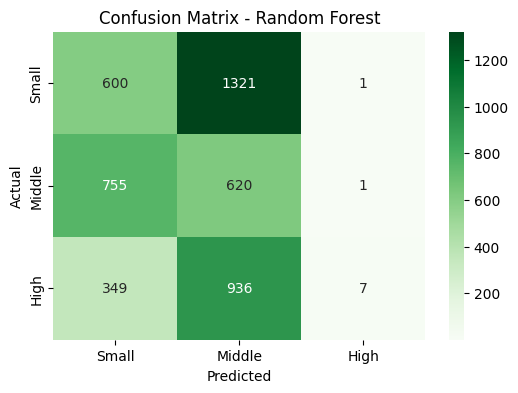

              precision    recall  f1-score   support

       Small       0.35      0.31      0.33      1922
      Middle       0.22      0.45      0.29      1376
        High       0.78      0.01      0.01      1292

    accuracy                           0.27      4590
   macro avg       0.45      0.26      0.21      4590
weighted avg       0.43      0.27      0.23      4590



In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions with Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=["Small", "Middle", "High"], yticklabels=["Small", "Middle", "High"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

print(classification_report(y_test, y_pred_rf, target_names=["Small", "Middle", "High"]))

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [10]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))


Counter({np.int64(0): 6001, np.int64(1): 4072, np.int64(2): 3972})
Counter({np.int64(0): 1922, np.int64(1): 1376, np.int64(2): 1292})


In [26]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
for train_idx, test_idx in logo.split(X, y, groups=participants):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    svm_model.fit(X_train, y_train)
    accuracy = svm_model.score(X_test, y_test)
    print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.59
Test Accuracy: 0.37
Test Accuracy: 0.44
Test Accuracy: 0.27
Test Accuracy: 0.24
Test Accuracy: 0.42
Test Accuracy: 0.53
Test Accuracy: 0.29


### Extract the data from `.npz` files

In [ ]:
X = list()
y = list()

logo = LeaveOneGroupOut()


for file in npz_files:
    file_path = os.path.join(dataset_dir, file)
    data = np.load(file_path)
    
    eit_data = data['eit']
    target_force = data['target_force']
    # flatten the eit data
    eit_data_flat = eit_data.reshape(-1)
    
    X.append(eit_data_flat)
    y.append(categorize_target_force(target_force))

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} samples, each with {X.shape[1]} features")


Loaded 18635 samples, each with 256 features


In [ ]:

groups = df["participant_id"].values  # Use participant ID for splitting

for train_index, test_index in logo.split(df.drop(columns=["label", "participant_id"]), df["label"], groups):
    X_train, X_test = df.iloc[train_index].drop(columns=["label", "participant_id"]), df.iloc[test_index].drop(columns=["label", "participant_id"])
    y_train, y_test = df.iloc[train_index]["label"], df.iloc[test_index]["label"]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Test participant:", groups[test_index][0])
    print(classification_report(y_test, y_pred))


## SVM Method

SVM Accuracy: 0.97


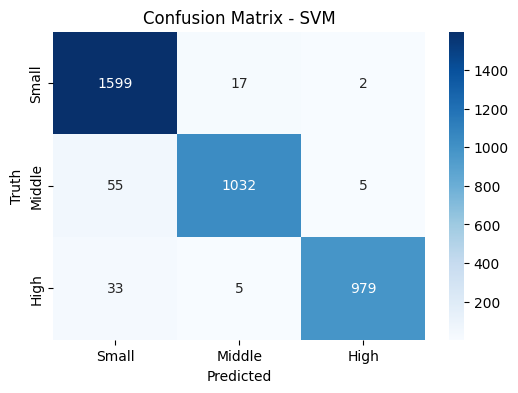

              precision    recall  f1-score   support

       Small       0.95      0.99      0.97      1618
      Middle       0.98      0.95      0.96      1092
        High       0.99      0.96      0.98      1017

    accuracy                           0.97      3727
   macro avg       0.97      0.97      0.97      3727
weighted avg       0.97      0.97      0.97      3727



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

# Initialize and train SVM model
svm_model = SVC(kernel='linear')  
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate SVM accuracy on the test set
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.2f}')

# Confusion matrix for SVM (only on test set)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["Small", "Middle", "High"], yticklabels=["Small", "Middle", "High"])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - SVM')
plt.show()

print(classification_report(y_test, y_pred_svm, target_names=["Small", "Middle", "High"]))

## Random Forest classification

Random Forest Accuracy: 1.00


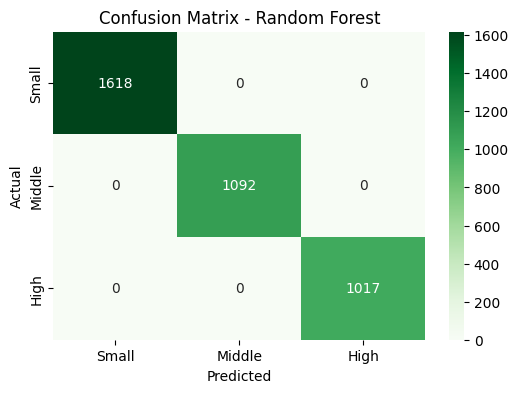

              precision    recall  f1-score   support

       Small       1.00      1.00      1.00      1618
      Middle       1.00      1.00      1.00      1092
        High       1.00      1.00      1.00      1017

    accuracy                           1.00      3727
   macro avg       1.00      1.00      1.00      3727
weighted avg       1.00      1.00      1.00      3727



In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions with Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=["Small", "Middle", "High"], yticklabels=["Small", "Middle", "High"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

print(classification_report(y_test, y_pred_rf, target_names=["Small", "Middle", "High"]))

## Classification for 7 Target force levels

In [7]:
X_all_target = list()
y_all_target = list()

for file in npz_files:
    file_path = os.path.join(dataset_dir, file)
    data = np.load(file_path)
    
    eit_data = data['eit']
    target_force = data['target_force']
    
    # flatten the eit data
    eit_data_flat = eit_data.reshape(-1)
    
    X_all_target.append(eit_data_flat)
    y_all_target.append(target_force)

X_all_target = np.array(X_all_target)
y_all_target = np.array(y_all_target)

print(f"Loaded {len(X_all_target)} samples, each with {X_all_target.shape[1]} features")

Loaded 18635 samples, each with 256 features


In [8]:
target_force = data['target_force']
target_force

array(70)

SVM Accuracy: 0.99


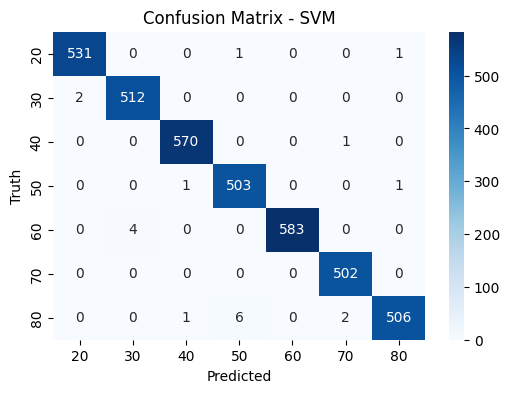

              precision    recall  f1-score   support

          20       1.00      1.00      1.00       533
          30       0.99      1.00      0.99       514
          40       1.00      1.00      1.00       571
          50       0.99      1.00      0.99       505
          60       1.00      0.99      1.00       587
          70       0.99      1.00      1.00       502
          80       1.00      0.98      0.99       515

    accuracy                           0.99      3727
   macro avg       0.99      0.99      0.99      3727
weighted avg       0.99      0.99      0.99      3727



In [9]:
# SVM
X_all_t_train, X_all_t_test, y_all_t_train, y_all_t_test = train_test_split(X_all_target, y_all_target, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_all_t_train = scaler.fit_transform(X_all_t_train) 
X_all_t_test = scaler.transform(X_all_t_test) 

# Initialize and train SVM model
svm_model = SVC(kernel='linear')  
svm_model.fit(X_all_t_train, y_all_t_train)

# Make predictions on the test set
y_pred_svm_all = svm_model.predict(X_all_t_test)

# Evaluate SVM accuracy on the test set
accuracy_svm_all = accuracy_score(y_all_t_test, y_pred_svm_all)
print(f'SVM Accuracy: {accuracy_svm_all:.2f}')

# Confusion matrix for SVM (only on test set)
cm_svm = confusion_matrix(y_all_t_test, y_pred_svm_all)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["20", "30", "40", "50", "60", "70", "80"], yticklabels=["20", "30", "40", "50", "60", "70", "80"])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - SVM')
plt.show()

print(classification_report(y_all_t_test, y_pred_svm_all, target_names=["20", "30", "40", "50", "60", "70", "80"]))

Random Forest Accuracy: 1.00


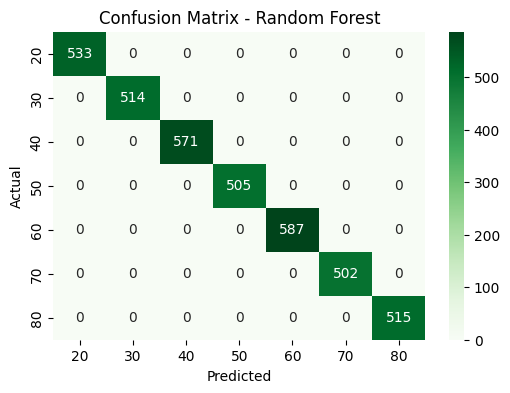

              precision    recall  f1-score   support

          20       1.00      1.00      1.00       533
          30       1.00      1.00      1.00       514
          40       1.00      1.00      1.00       571
          50       1.00      1.00      1.00       505
          60       1.00      1.00      1.00       587
          70       1.00      1.00      1.00       502
          80       1.00      1.00      1.00       515

    accuracy                           1.00      3727
   macro avg       1.00      1.00      1.00      3727
weighted avg       1.00      1.00      1.00      3727



In [10]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_all_t_train, y_all_t_train)

# Make predictions with Random Forest
y_pred_rf = rf_model.predict(X_all_t_test)

# Evaluate Random Forest accuracy
accuracy_rf = accuracy_score(y_all_t_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_all_t_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=["20", "30", "40", "50", "60", "70", "80"], yticklabels=["20", "30", "40", "50", "60", "70", "80"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

print(classification_report(y_all_t_test, y_pred_rf, target_names=["20", "30", "40", "50", "60", "70", "80"]))